# import packages

In [1]:
#Import Pacakges
import pandas as pd
from sbmtm import sbmtm
import graph_tool.all as gt
import pickle
import numpy as np
import pylab as plt
import seaborn as sns
from datetime import datetime
from dateutil import parser
from collections import defaultdict

In [2]:
def mcc_classification(mcc):
    if mcc < 1500:
        return 'Agricultural Services'
    elif mcc < 3000:
        return 'Contracted Services'
    elif mcc < 4800:
        return 'Travel'
    elif mcc < 5000:
        return 'Utility Services'
    elif mcc < 5600:
        return 'Retail Outlet Services'
    elif mcc < 5700:
        return 'Clothing Stores'
    elif mcc < 7300:
        return 'Miscellaneous Stores'
    elif mcc < 8000:
        return 'Business Services'
    elif mcc < 9000:
        return 'Professional Services and Membership Organizations'
    else:
        return 'Government Services'

In [3]:
#filtered_data = pd.read_csv('/Users/ognyansimeonov/Desktop/MAC-MIGS/PhD/Code/Data/Transactions_Data_with_COICOP.csv')
filtered_data = pd.read_excel('ekko_Data_MSc.xlsx', sheet_name='Clean_Transfers')
mcc_dict = pd.read_excel('ekko_Data_MSc.xlsx', sheet_name='MCC_List', skiprows=10, usecols='A:B', names=['mcc_code', 'Description'])

### data cleaning

# deal with mcc that are classified into multiple categories (keep the main category)
tempdf = filtered_data.groupby('MCC_List')['externalParty.transactionCategory'].value_counts(ascending=False).reset_index()
tempdf = tempdf.drop_duplicates(subset=['MCC_List'], keep='first')
# remap the categories to the filtered_data
filtered_data['externalParty.transactionCategory'] = filtered_data['MCC_List'].map(tempdf.set_index('MCC_List')['externalParty.transactionCategory'])

# select transactions with amount > 10
filtered_data = filtered_data[filtered_data['amount.value'] > 10]
# select customers with more than 10 transactions
filtered_data = filtered_data[filtered_data['customerId'].map(filtered_data['customerId'].value_counts()) > 10]
# map the mcc_dict to the filtered_data and drop the rows with NaN MCC values
filtered_data['MCC_List'] = filtered_data['externalParty.merchantCategoryCode'].map(mcc_dict.set_index('mcc_code')['Description'])
filtered_data = filtered_data.dropna(subset=['MCC_List'])
# fill the missing carbon emission values with the calculated carbon emission values based on the emission rate of the MCC
# calculate the emission rate of each transaction
filtered_data['emission_rate'] = filtered_data.apply(lambda x: x['transactionFootPrint.carbonEmissionInGrams']/x['amount.value'] if x['amount.value']!=0 else 0, axis=1)
# find the emission rate of each MCC
df_emission_rate = filtered_data.groupby('MCC_List')['emission_rate'].max().sort_values(ascending=True).reset_index().set_index('MCC_List').fillna(0)
# calculate the carbon emission of each transaction where missing
filtered_data['transactionFootPrint.carbonEmissionInGrams'] = filtered_data.apply(lambda x: x['amount.value']*df_emission_rate.loc[x['MCC_List']], axis=1)
filtered_data['mcc_classification'] = filtered_data['externalParty.merchantCategoryCode'].apply(mcc_classification)

df = filtered_data 

# Create a dictionary to store MCC lists for each customer
customer_mcc_dict = {}

# Iterate through the dataframe
for _, row in df.iterrows():
    customer_id = row['customerId']
    mcc = row['MCC_List']

    # Check if the customer_id is already in the dictionary
    if customer_id in customer_mcc_dict:
        customer_mcc_dict[customer_id].append(mcc)
    else:
        customer_mcc_dict[customer_id] = [mcc]

# build a network

<Axes: ylabel='Frequency'>

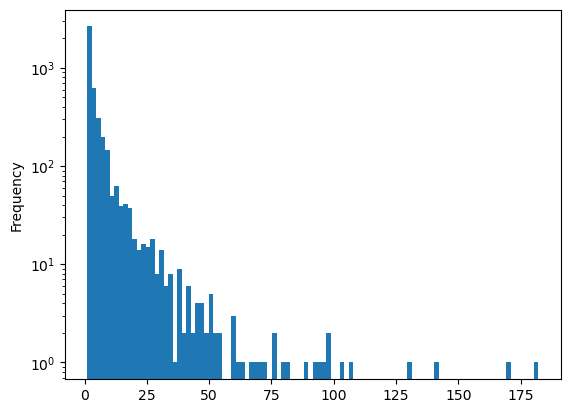

In [4]:
df_freq = filtered_data.groupby('customerId')['MCC_List'].value_counts().reset_index(name='count')
df_freq['count'].plot(
                        kind='hist'
                      , bins=100
                      , logy=True
                      )

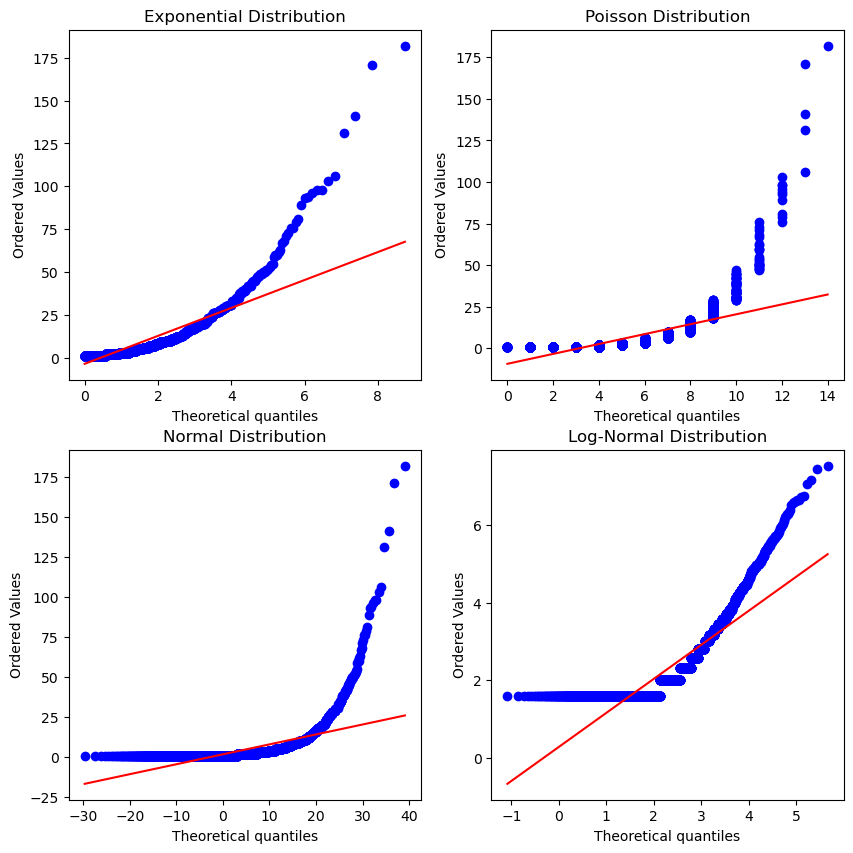

In [5]:
# plot the qq plot of frequency with the exponential distribution, normal distribution, and poisson distribution
import scipy.stats as stats

# all plots in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

data = df_freq['count']
# data = np.log(df_freq['count'])
# data = np.log10(df_freq['count'])

# Exponential distribution
stats.probplot(data, dist="expon", plot=axs[0, 0])
axs[0, 0].set_title('Exponential Distribution')

# Poisson distribution
mu = data.mean()
stats.probplot(data, dist="poisson", sparams=(mu,), plot=axs[0, 1])
axs[0, 1].set_title('Poisson Distribution')

# Normal distribution
mu, std = stats.norm.fit(data)

stats.probplot(data, dist="norm", sparams=(mu, std), plot=axs[1, 0])
axs[1, 0].set_title('Normal Distribution')

# log-normal distribution
mu, std = stats.norm.fit(np.log2(data+2))
stats.probplot(np.log2(data+2), dist="norm", sparams=(mu, std), plot=axs[1, 1])
axs[1, 1].set_title('Log-Normal Distribution')
plt.show()


In [6]:
# perform a statistical test to check if the frequency of transactions follows a exponential distribution
print("Exponential test: ", stats.kstest(data, 'expon'))

# perform a statistical test to check if the frequency of transactions follows a poisson distribution
print("Poisson test: ", stats.kstest(data, 'poisson', args=(data.mean(),)))

# perform a statistical test to check if the frequency of transactions follows a normal distribution
print("Normal test: ", stats.kstest(data, 'norm', args=(data.mean(), data.std())))

# perform a statistical test to check if the frequency of transactions follows a normal distribution
print("Log-normal test: ", stats.kstest(np.log2(data+2), 'norm', args=(np.log2(data+2).mean(), np.log2(data+2).std())))

Exponential test:  KstestResult(statistic=0.6321205588285577, pvalue=0.0, statistic_location=1, statistic_sign=-1)
Poisson test:  KstestResult(statistic=0.4585427357578943, pvalue=0.0, statistic_location=2, statistic_sign=1)
Normal test:  KstestResult(statistic=0.34921339921799577, pvalue=0.0, statistic_location=1, statistic_sign=-1)
Log-normal test:  KstestResult(statistic=0.23197184536646875, pvalue=5.588331468328938e-205, statistic_location=2.0, statistic_sign=1)


<Axes: ylabel='Frequency'>

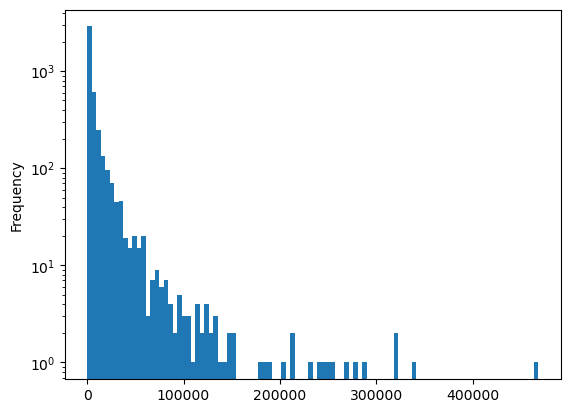

In [7]:
df_weight_network = filtered_data.groupby(['customerId','MCC_List'])['amount.value'].sum().reset_index()
df_weight_network['amount.value'].plot(
                                        kind='hist'
                                       , bins=100
                                       , logy=True
                                       )

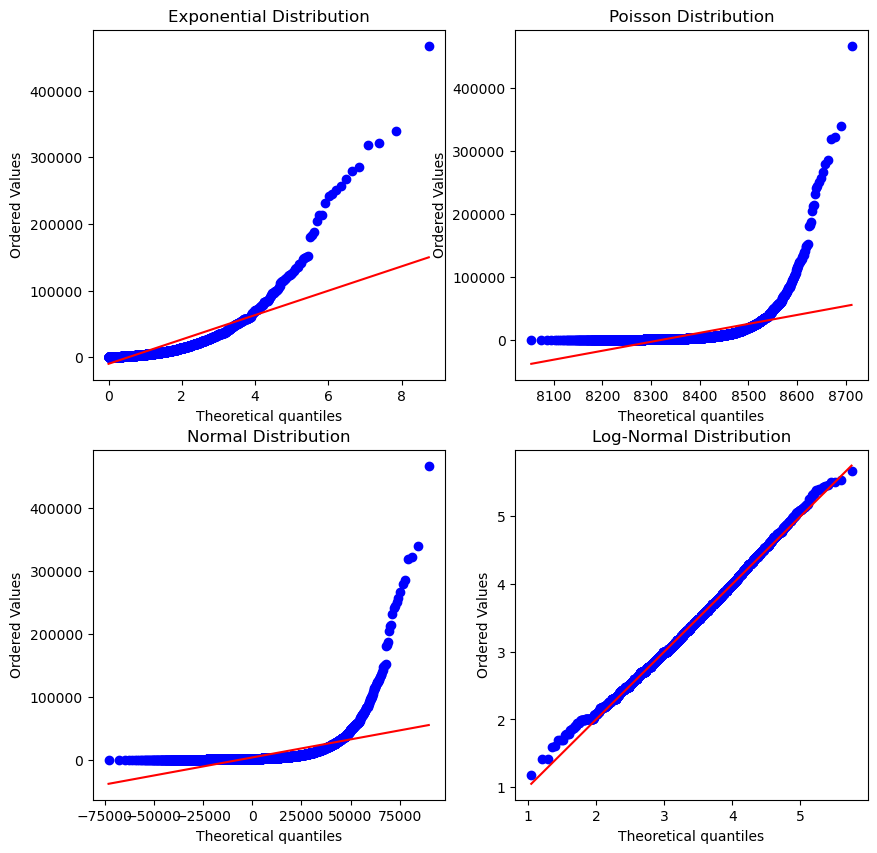

In [8]:
data = df_weight_network['amount.value']
# data = np.log(df_weight_network['amount.value'])
# data = np.log10(df_weight_network['amount.value'])

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Exponential distribution
stats.probplot(data, dist="expon", plot=axs[0, 0])
axs[0, 0].set_title('Exponential Distribution')

# Poisson distribution
stats.probplot(data, dist="poisson", sparams=(data.mean(),), plot=axs[0, 1])
axs[0, 1].set_title('Poisson Distribution')

# Normal distribution
mu, std = stats.norm.fit(data)
stats.probplot(data, dist="norm", sparams=(mu, std), plot=axs[1, 0])
axs[1, 0].set_title('Normal Distribution')

# log-normal distribution
mu, std = stats.norm.fit(np.log10(data))
stats.probplot(np.log10(data), dist="norm", sparams=(mu, std), plot=axs[1, 1])
axs[1, 1].set_title('Log-Normal Distribution')
plt.show()

cvm Statistics:  0.5256873288282825 , p-value:  0.0324


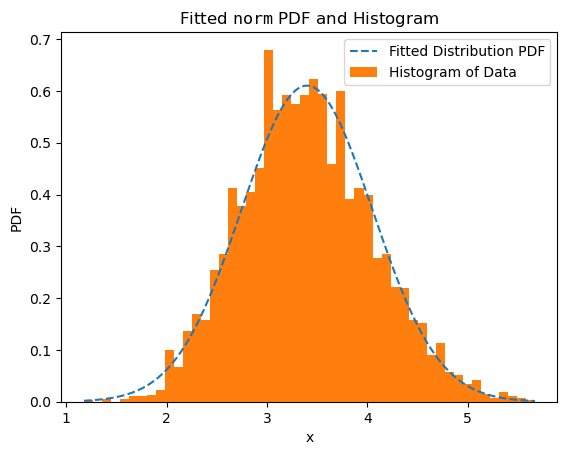

In [10]:
rng = np.random.default_rng(seed=41)

data = np.log10(df_weight_network['amount.value'])
mu, std = stats.norm.fit(data)

known_params = {'loc': mu, 'scale': std}
method = 'cvm'
# method = 'filliben'
# method = 'ad'
# method = 'ks'

res = stats.goodness_of_fit(stats.norm, data, known_params=known_params,
                            random_state=rng, statistic=method)
print("cvm Statistics: ", res.statistic, ", p-value: ", res.pvalue)
res.fit_result.plot()
plt.show()

In [16]:
df_weight_network

,customerId,MCC_List,amount.value
0,01968de9-41cb-4509-b0a6-6bdc02700150,Bakeries,1265
1,01968de9-41cb-4509-b0a6-6bdc02700150,Beauty and Barber Shops,5057
2,01968de9-41cb-4509-b0a6-6bdc02700150,"Bus Lines, includes Charters/Tour Buses",3570
3,01968de9-41cb-4509-b0a6-6bdc02700150,"Candy, Nut, and Confectionary Stores",490
4,01968de9-41cb-4509-b0a6-6bdc02700150,Caterers - Prepare & Delivery,1445
...,...,...,...
4317,ffcf3506-a7d8-48a0-ba54-d4d54d15ee78,Shoe Stores,4319
4318,ffcf3506-a7d8-48a0-ba54-d4d54d15ee78,Sporting and Recreational Camps,1465
4319,ffcf3506-a7d8-48a0-ba54-d4d54d15ee78,"Stationery, Office and School Supply Stores",2240
4320,ffcf3506-a7d8-48a0-ba54-d4d54d15ee78,Tourist Attractions and Exhibits,200


In [19]:
# build a weighted network
g = gt.Graph(directed=False)
# difine the node properties
## name: docs - title, words - 'word'
## kind: docs(customers) - 0, words(mcc) - 1
name = g.vp['name'] = g.new_vp('string')
kind = g.vp['kind'] = g.new_vp('int')
## define the edge properties
weight = g.ep['weight'] = g.new_ep('double')

docs_add = defaultdict(lambda: g.add_vertex())
words_add = defaultdict(lambda: g.add_vertex())

for _, row in df_weight_network.iterrows():
    customer = row['customerId']
    mcc = row['MCC_List']
    weight = np.log10(row['amount.value'])
    # weight = row['amount.value']
    # add customer node
    docs = docs_add[customer]
    name[docs] = customer
    kind[docs] = 0
    # add mcc node
    words = words_add[mcc]
    name[words] = mcc
    kind[words] = 1
    edge = g.edge(docs, words)
    if edge is None:
        edge = g.add_edge(docs, words)
        g.ep['weight'][edge] = 0
    g.ep['weight'][edge] += weight

# Nested SBM

In [20]:
SEED = 41
gt.seed_rng(SEED)

n_init = 10
clabel = g.vp['kind']

state_args = {'clabel': clabel
              , 'pclabel': clabel
            #   , 'eweight': g.ep['weight']
              , 'recs':[g.ep.weight]
            #   , 'rec_types': ['real-exponential']
              , 'rec_types': ['real-normal']
              }

mdl = np.inf
for i_n_init in range(n_init):
    base_type = gt.BlockState
    state_tmp = gt.minimize_nested_blockmodel_dl(g,
                                                 state_args=dict(base_type=base_type,**state_args),multilevel_mcmc_args=dict(niter=1, verbose=False)
                                                 )
    L = 0
    for s in state_tmp.levels:
        L += 1
        if s.get_nonempty_B() == 2:
            break
    state_tmp = state_tmp.copy(bs=state_tmp.get_bs()[:L] + [np.zeros(1)])
    print(state_tmp.entropy())

    mdl_tmp = state_tmp.entropy()
    if mdl_tmp < mdl:
        mdl = 1.0*mdl_tmp
        state = state_tmp.copy()

g.state = state
g.mdl = state.entropy()
L = len(state.levels)
if L == 2:
    g.L = 1
else:
    g.L = L-2

In [13]:
print('The lowest entropy was {}, and the state has {} blocks at level 1'.format(g.state.entropy(),g.state.get_levels()[1].get_nonempty_B()))

The lowest entropy was 125559.24286575399, and the state has 255 blocks at level 1


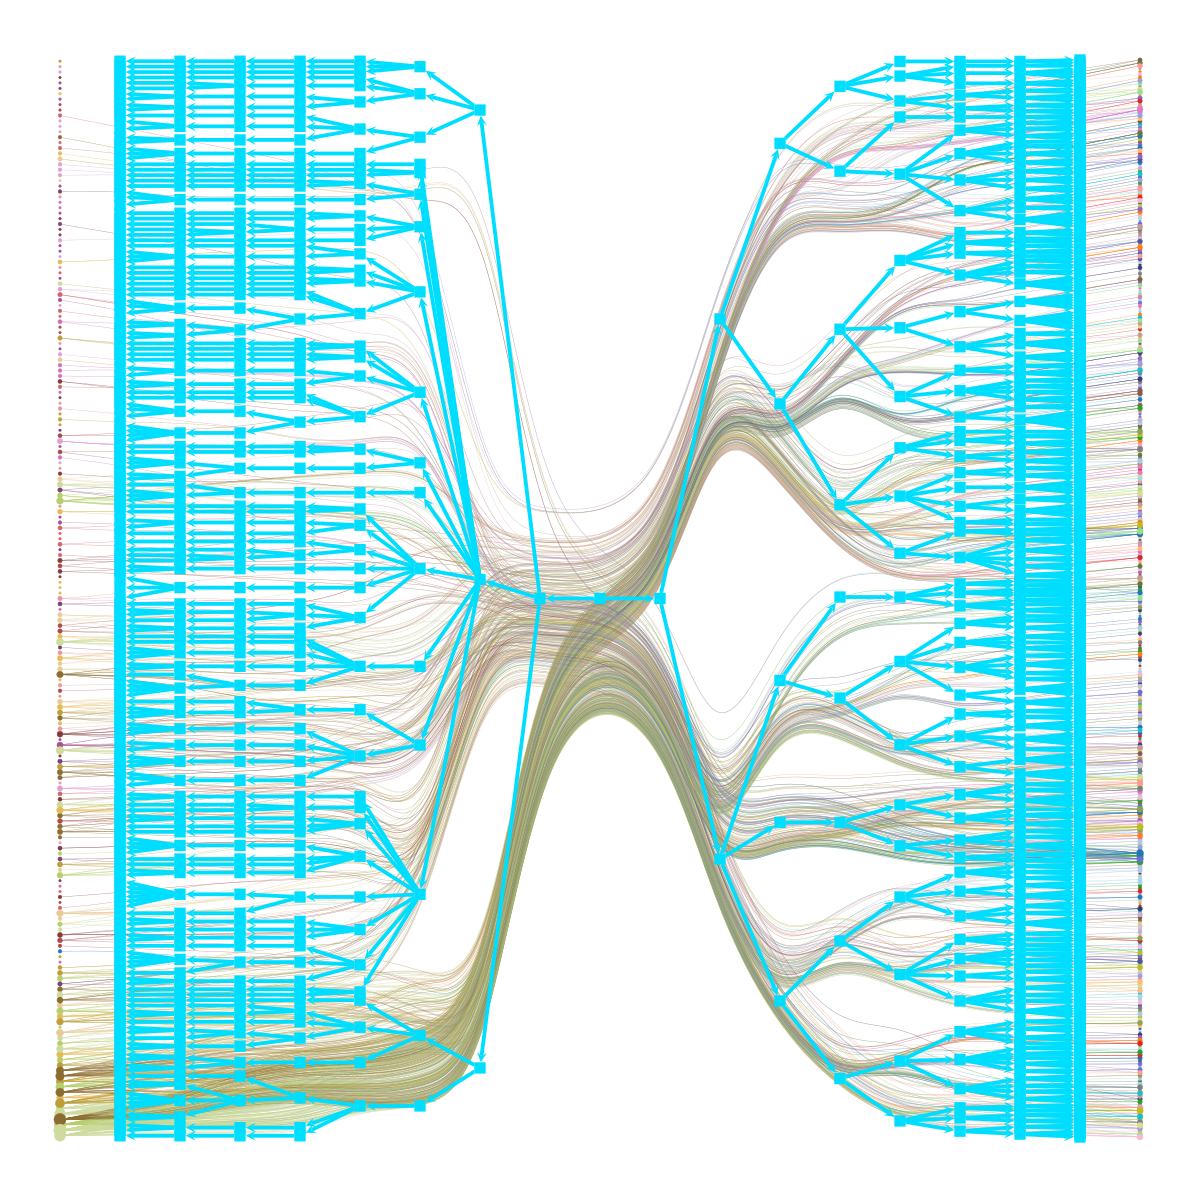

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f4894185400, at 0x7f4895c9a2a0>,
 <GraphView object, directed, with 1734 vertices and 1733 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f48b018a150, at 0x7f4895e1a9c0>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f48b018a150, at 0x7f4895e1ab10>, False), at 0x7f48b018a150>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f48b018a150, at 0x7f48944632f0>)

In [14]:
g.state.draw(subsample_edges=1000,layout='bipartite',bip_aspect=1,
           hvertex_size=8, hedge_pen_width=1.9, hedge_color="#00deff", hvertex_fill_color="#00DEFF", output_size=(600, 600))

In [15]:
state_l0 = g.state.project_level(0).copy()
state_l1 = g.state.project_level(1).copy()

In [16]:
b0 = gt.contiguous_map(state_l0.b)
b1 = gt.contiguous_map(state_l1.b)
label_map = {}
for v in g.vertices():
    label_map[state_l0.b[v]] = b0[v]
state_l0 = state_l0.copy(b=b0)
state_l1 = state_l1.copy(b=b1)

In [17]:
# create a dict for nodes and their blocks
blocks = {}
for v in g.vertices():
    blocks[name[v]] = [kind[v], state_l1.get_blocks()[v], state_l0.get_blocks()[v]]

In [18]:
df_clusters = pd.DataFrame.from_dict(blocks, orient='index', columns=['kind', 'level_1', 'level_0']).reset_index()
df_clusters = df_clusters.rename(columns={'index':'node'})
df_clusters['node'] = df_clusters['node'].astype(str)
df_clusters['levels'] = df_clusters['level_1'].astype(str) + '_' + df_clusters['level_0'].astype(str)
df_clusters.sort_values(by=['kind','level_1','level_0'], ascending=True, inplace=True)
df_clusters = df_clusters[df_clusters['kind'] == 0].reset_index(drop=True)
df_clusters.reset_index(drop=True, inplace=True)
df_clusters

,node,kind,level_1,level_0,levels
0,01968de9-41cb-4509-b0a6-6bdc02700150,0,0,0,0_0
1,01b34ce5-ce43-4c2d-a73d-5294376bd399,0,27,34,27_34
2,e0489c24-35d2-402a-a794-38d9e5dfa812,0,27,500,27_500
3,01b4698f-32be-4bc0-9b69-b3024ac18004,0,32,39,32_39
4,0f079bbb-ef8d-4709-b1a0-dde0267af018,0,32,91,32_91
...,...,...,...,...,...
364,e53e257f-6d4e-4a1a-a843-a38ebb0a2a51,0,249,509,249_509
365,ea27dd28-fded-452f-bc14-c1ff02689d8d,0,250,520,250_520
366,f62c7154-a4a8-4085-ac99-aac7ae6ba660,0,250,539,250_539
367,fcfd36e4-da5e-42d1-8769-8213878b08fe,0,252,550,252_550


In [20]:
df_clusters['level_0'].nunique()

369

In [330]:
df_clusters['levels'].unique()

array(['0_0', '0_33', '0_36', '0_42', '0_52', '0_54', '0_58', '0_66',
       '0_78', '0_79', '0_86', '8_22', '8_44', '8_47', '8_61', '8_63',
       '8_71', '8_74', '8_76', '8_77', '8_81', '8_82', '8_83', '8_85',
       '8_88', '8_89', '8_92', '9_26', '9_53', '9_67', '9_84', '10_28',
       '10_48', '10_51', '10_65', '10_75', '10_91', '11_37', '11_39',
       '11_40', '11_55', '11_57', '11_64', '11_68', '11_69', '11_70',
       '11_90', '13_56', '13_73', '13_80', '13_87'], dtype=object)

In [335]:
df_clusters[df_clusters['levels'] == '0_0']['node'].values

array(['01968de9-41cb-4509-b0a6-6bdc02700150',
       '4dd438c3-69e1-4520-9fb0-00c43c6fe02f',
       '769072e1-9022-44ce-b416-9f727745201c'], dtype=object)

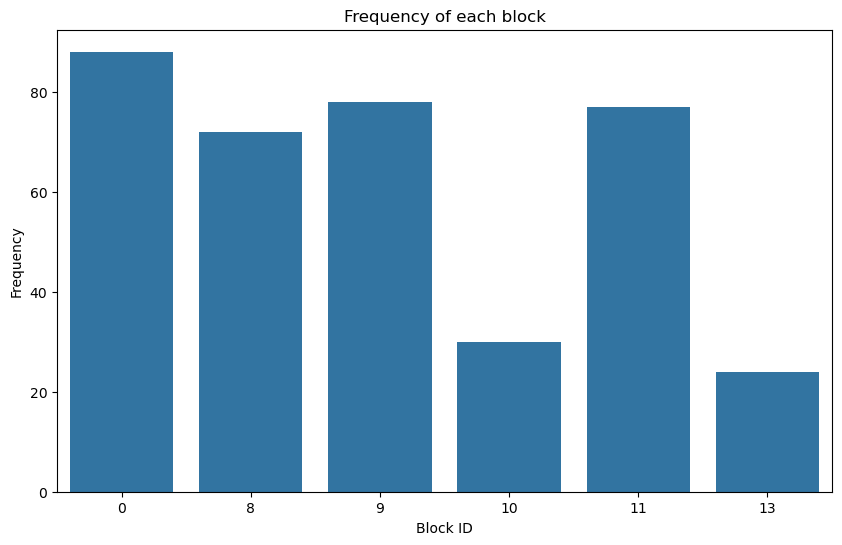

In [331]:
# calculate the frequency of each block and sort them by the id of the block
block_freq = {}
l=1
for i in df_clusters['level_{}'.format(l)].unique():
    # block_freq[str(i)] = len([x for x in b if x == i])
    block_freq[i] = len(df_clusters[df_clusters['level_{}'.format(l)] == i])
# plot the frequency of each block
plt.figure(figsize=(10, 6))
sns.barplot(x=list(block_freq.keys()), y=list(block_freq.values()))
plt.xlabel('Block ID')
plt.ylabel('Frequency')
plt.title('Frequency of each block')
plt.show()

In [ ]:
yvalues = []
if len(yvalues) > 2:
    print('The number of yvalues is greater than 2')
    break
else:
    df_avg = filtered_data.groupby(yvalues[-1])['customerId'].nunique().sort_values(ascending=False).rename('nunique_customers').reset_index()
    df_avg['idf'] = np.log(len(CustomerID)/df_avg['nunique_customers'])
    df_avg = df_avg.set_index('MCC_List')
    df_avg['proportion'] = filtered_data['MCC_List'].value_counts(normalize=True)
    df_avg.head()

In [336]:
filtered_data.head()

,_id,accountId,customerId,IMD_Decile,createdAt,amount.currency,amount.exponent,amount.value,externalParty.merchantCategoryCode,externalParty.transactionCategory,MCC_List,transactionFootPrint.carbonEmissionInGrams,transactionType.code,transactionType.direction,emission_rate,mcc_classification
0,6220c8e159378700114a8722,61c5e725941a0600135559cf,4ec3aa2c-1dcd-47a7-b20c-ce7083ddbab8,9,2022-03-03T13:55:45.434Z,GBP,2,5067,742,OTHER,Veterinary Services,10048.033278,REDEMPTION,DEBIT,1.944456,Agricultural Services
1,62c30db86daa10001266325e,6215fbb82c463a001166ad8f,a4c47159-e445-4b31-8ea9-6c5852bd7095,8,2022-07-04T15:56:40.950Z,GBP,2,4600,742,OTHER,Veterinary Services,9121.956400,REDEMPTION,DEBIT,1.983033,Agricultural Services
2,62e0fcf555577b00112d3176,625e873608ff4300110c62af,b5a28615-7994-458e-8903-8086ac77eb49,Not_Found,2022-07-27T08:53:09.433Z,GBP,2,5000,742,OTHER,Veterinary Services,9915.170000,REDEMPTION,DEBIT,1.983034,Agricultural Services
4,62c44ba62e447d00129fc612,61c453eebcc5e4001133f68a,fd654d64-f795-401d-a5fe-76cfa2cfa01a,10,2022-07-05T14:33:10.080Z,GBP,2,600,1520,SHOPPING,General Contractor/Residential Building,15224.930000,REDEMPTION,DEBIT,25.374883,Contracted Services
5,62c5589f756f3f00119ec3b4,61c453eebcc5e4001133f68a,fd654d64-f795-401d-a5fe-76cfa2cfa01a,10,2022-07-06T09:40:47.483Z,GBP,2,600,1520,SHOPPING,General Contractor/Residential Building,15224.930000,REDEMPTION,DEBIT,25.374883,Contracted Services


In [394]:
(df.groupby('MCC_List')['amount.value'].sum()/df['amount.value'].sum()).rename('proportion').sort_values(ascending=False).reset_index().set_index('MCC_List')

,proportion
MCC_List,
Financial Institutions--Automated Cash Disbursements,0.240745
Grocery Stores and Supermarkets,0.120532
Eating Places and Restaurants,0.104479
Service Stations (with or without Ancillary Services),0.032992
Quick Payment Service-Fast Food Restaurants,0.031815
...,...
Railroads,0.000008
Child Care Services,0.000008
Durable Goods Not Elsewhere Classified (Business to Business MCC),0.000007


In [426]:
filtered_data['y'].value_counts(normalize=True).reset_index().set_index('y')

,proportion
y,
GROCERIES,0.274995
LIFESTYLE,0.267811
TRAVEL,0.179738
SHOPPING,0.151840
OTHER,0.125369
FUEL,0.000246


## Heatmaps of Purchases by Cluster

In [427]:
def heatmaps(df_clusters, df, yvalues=['MCC_List'], xvalues=['levels'], topn=False, relative=False, value='frequency', level_detail=False, max_label_len=False):
    '''
    df_clusters: DataFrame, the DataFrame with the cluster information
    df: DataFrame, the DataFrame with the transactions data
    yvalues: list, hierarchical levels to be used as y-axis values (categories)
    xvalues: list, hierarchical levels to be used as x-axis values (levels)
    topn: int, the number of top categories to be shown in the heatmap, valid only if yvalues has one level
    relative: bool, if True, the heatmap will show the relative frequency of the categories
    '''
    if len(yvalues) == 2:
        df['y'] = df[yvalues[0]] + '_' + df[yvalues[1]]
        annot = False
        ytick = False
    else:
        df['y'] = df[yvalues[0]]
        annot = True
        ytick = True
    # population average of the transactions frequency/amount for calculating the relative frequency
    if value == 'frequency':
        df_avg = df['y'].value_counts(normalize=True).reset_index().set_index('y')
        df['count'] = 1
    elif value == 'amount':
        df_avg = (df.groupby('y')['amount.value'].sum()/df['amount.value'].sum()).rename('proportion').reset_index().set_index('y')
        df['count'] = df['amount.value']

    # Get the normalized MCC transaction counts for each cluster
    cluster_counts = []
    for cluster in df_clusters[xvalues[-1]].unique():
        # Filter the DataFrame based on the customer IDs in the cluster
        custid = df_clusters[df_clusters[xvalues[-1]] == cluster]['node'].values
        filtered_df = df[df['customerId'].isin(custid)]
        if relative:
            # Calculate the normalized counts for each MCC category
            # counts = np.log(filtered_df[yvalues[-1]].value_counts(normalize=True) / df_avg['proportion']).rename(cluster)
            counts = np.log((filtered_df.groupby('y')['count'].sum()/filtered_df['count'].sum()) / df_avg['proportion']).rename(cluster)
        else:
            counts = (filtered_df.groupby('y')['count'].sum()/filtered_df['count'].sum()).rename(cluster)
        cluster_counts.append(counts)

    # Combine the normalized counts into a single DataFrame
    df_data = pd.concat(cluster_counts, axis=1, sort=True).fillna(0)
    # limit the length of the index
    if max_label_len:
        df_data.index = df_data.index.map(lambda x: x[:max_label_len]+'...' if len(x) > max_label_len else x)
        df_avg.index = df_avg.index.map(lambda x: x[:max_label_len]+'...' if len(x) > max_label_len else x)
    limit = np.max([np.abs(df_data.min().min()), df_data.max().max()])

    # shows only the top mcc if topn is given
    if topn:
        # Get the top 10 categories with the highest average transaction percentages
        topn_index = df_avg.nlargest(topn, df_avg.keys()[0]).index
        # Filter the DataFrame to keep only the top categories
        df_data = df_data.loc[topn_index]

    # Create a heatmap
    plt.figure(figsize=(18, 10))
    if relative:
        sns.heatmap(df_data, cmap='PiYG', fmt='.2f', annot=annot, linewidths=.5, vmin=-limit, vmax=limit, yticklabels=ytick, xticklabels=level_detail)
    else:
        sns.heatmap(df_data, cmap='Reds', fmt='.2%', annot=annot, linewidths=.5, yticklabels=ytick, xticklabels=level_detail)
    if len(yvalues) == 2:
        for category, y in df.groupby(yvalues[0])['y'].nunique().sort_index().cumsum().items():
            plt.axhline(y=y, color='gray', lw=0.5, linestyle='--')
            plt.text(-1, y-0.5, category, ha='center', va='center', fontsize=8)
    if len(xvalues) == 2:
        y = len(df_data.index)
        for level, x in df_clusters.groupby(xvalues[0])[xvalues[1]].nunique().sort_index().cumsum().items():
            plt.axvline(x=x, color='gray', lw=0.5, linestyle='--')
            if level_detail == False:
                plt.text(x-0.5, y*1.01, level, ha='center', va='center', fontsize=8)
    plt.title('Normalized MCC Categories Heatmap')
    plt.show()

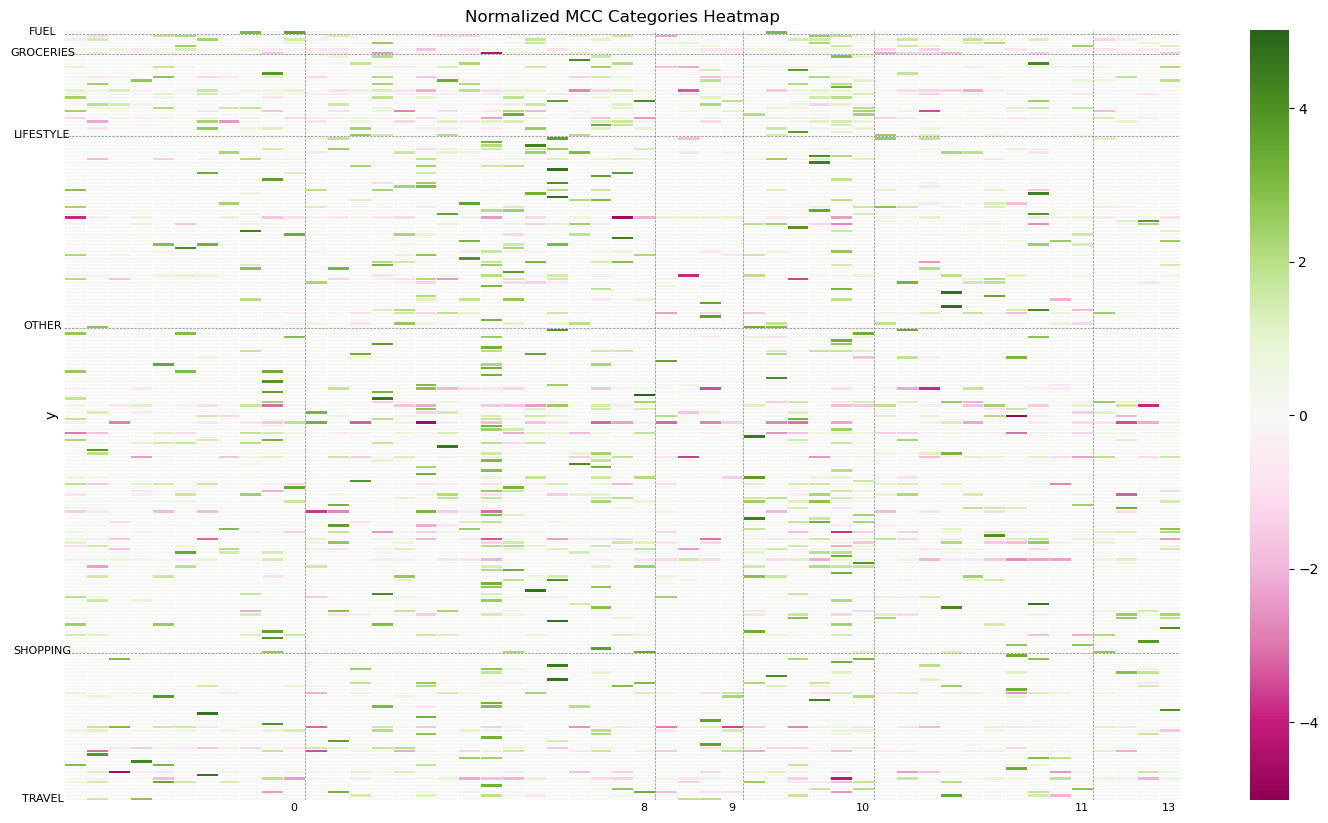

In [428]:
heatmaps(df_clusters, filtered_data, relative=True, yvalues=['externalParty.transactionCategory','MCC_List'], xvalues=['level_1','levels'], level_detail=False, value='amount')

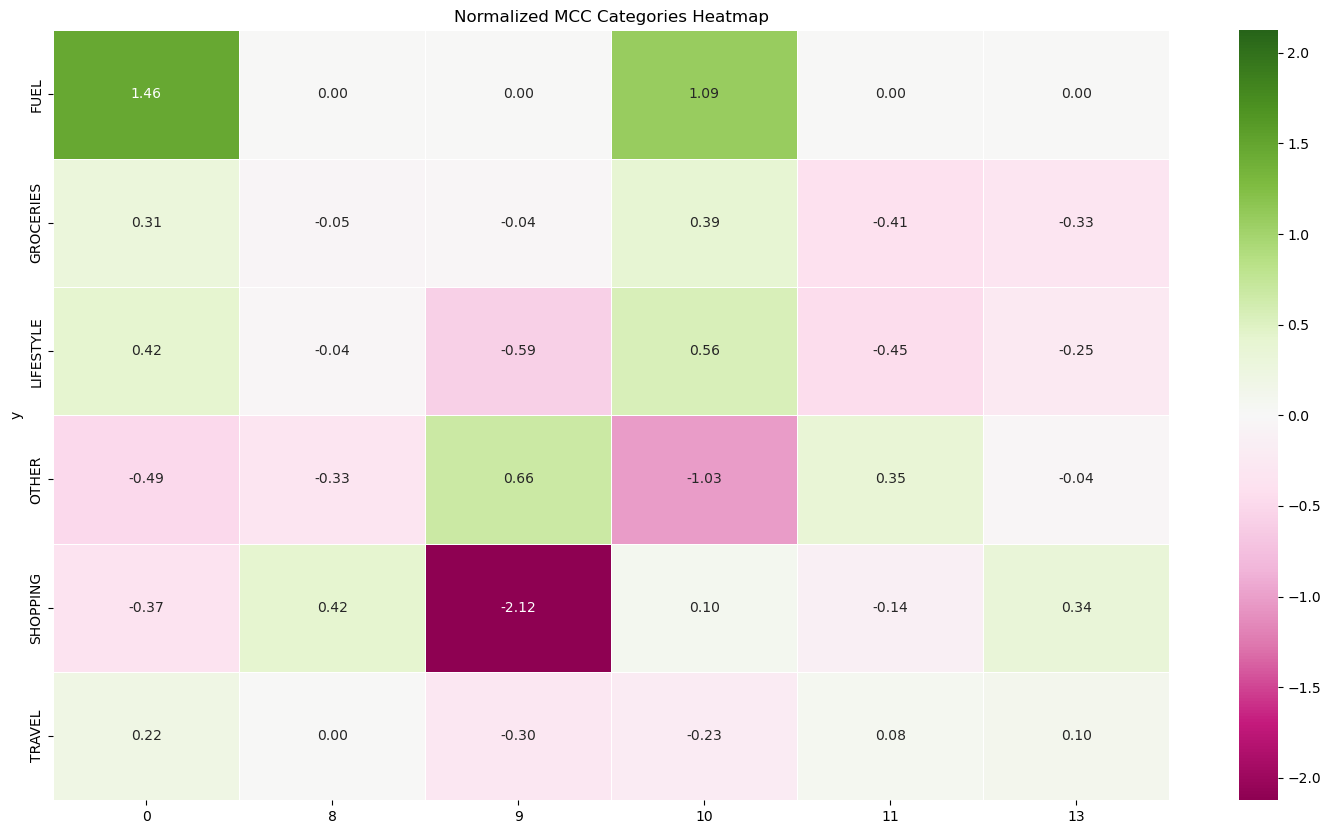

In [429]:
heatmaps(df_clusters, filtered_data, relative=True, yvalues=['externalParty.transactionCategory'], xvalues=['level_1'], level_detail=True, value='amount')

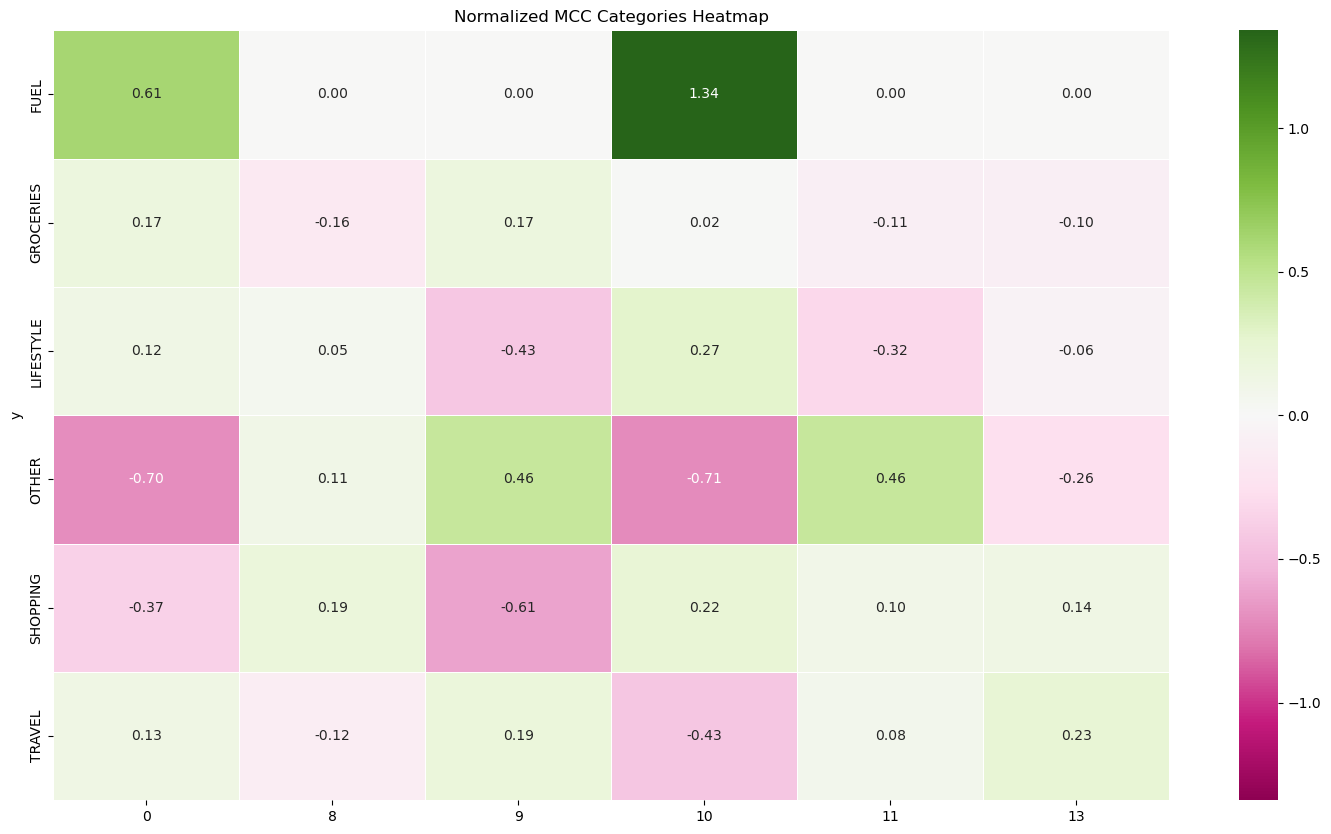

In [430]:
heatmaps(df_clusters, filtered_data, relative=True, yvalues=['externalParty.transactionCategory'], xvalues=['level_1'], level_detail=True, value='frequency')

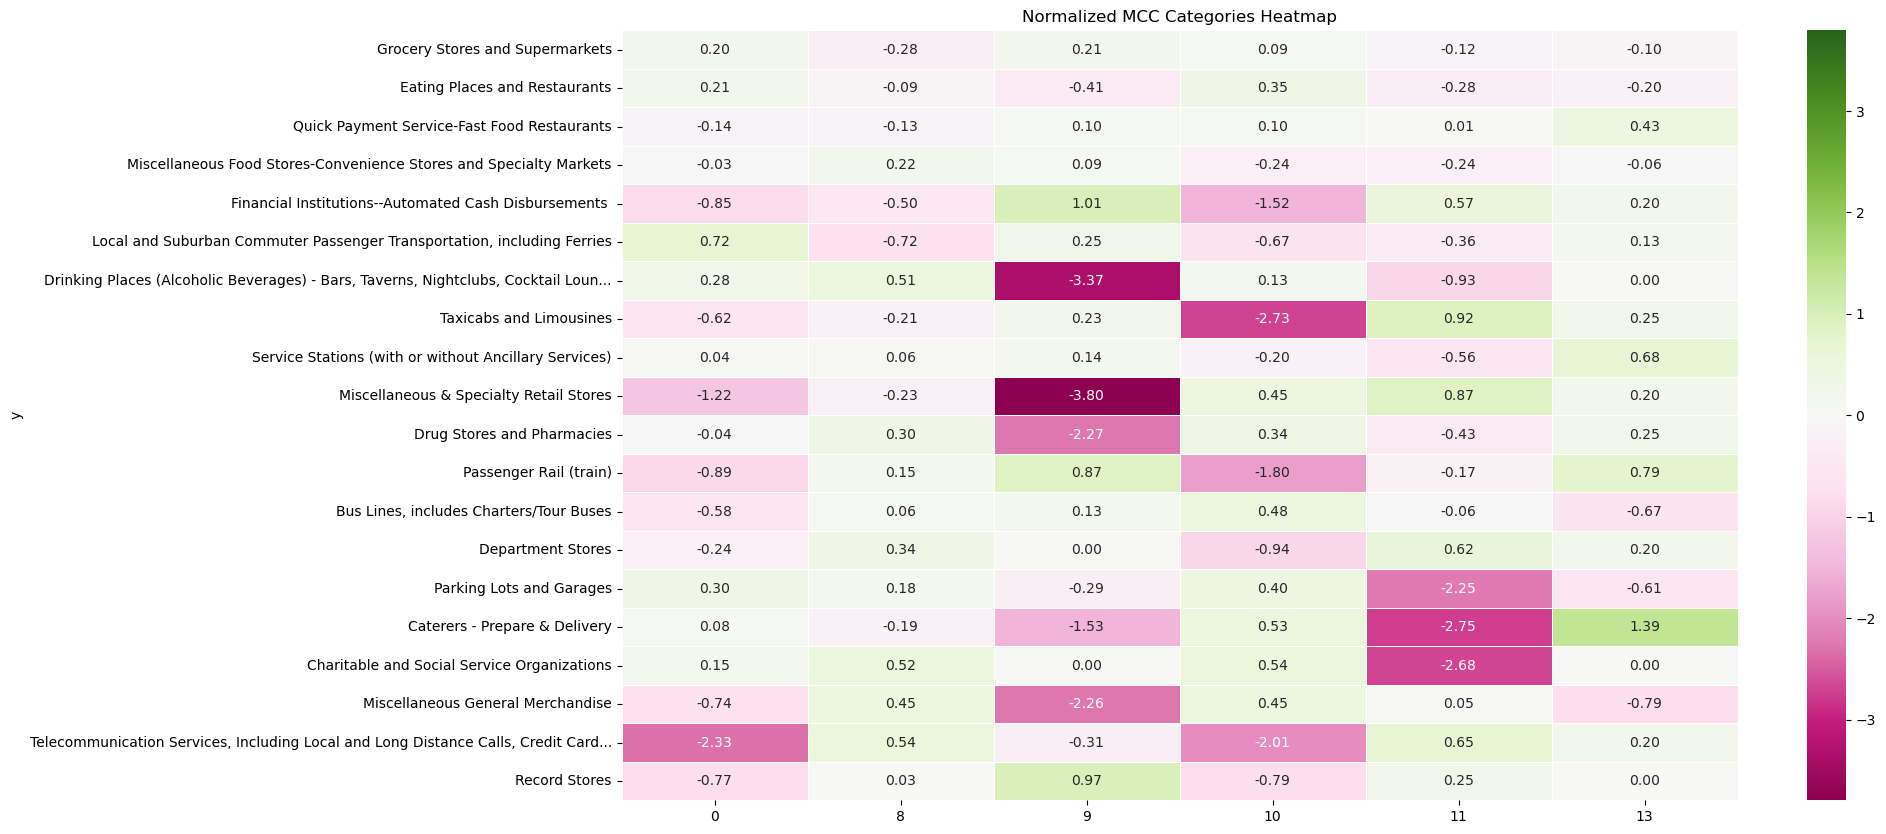

In [433]:
heatmaps(df_clusters, filtered_data, relative=True, yvalues=['MCC_List'], xvalues=['level_1'], level_detail=True, value='frequency', topn=20, max_label_len=80)